In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [ ]:
df = pd.read_csv('/content/AB_NYC_2019.csv')


In [ ]:
df

id                                               name   host_id  \
0          2539                 Clean & quiet apt home by the park      2787   
1          2595                              Skylit Midtown Castle      2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
3          3831                    Cozy Entire Floor of Brownstone      4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park      7192   
...         ...                                                ...       ...   
48890  36484665    Charming one bedroom - newly renovated rowhouse   8232441   
48891  36485057      Affordable room in Bushwick/East Williamsburg   6570630   
48892  36485431            Sunny Studio at Historical Neighborhood  23492952   
48893  36485609               43rd St. Time Square-cozy single bed  30985759   
48894  36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

           host_name neighbourhood_group       neighbourhood  latitude  \
0               John            Brooklyn          Kensington  40.64749   
1           Jennifer           Manhattan             Midtown  40.75362   
2          Elisabeth           Manhattan              Harlem  40.80902   
3        LisaRoxanne            Brooklyn        Clinton Hill  40.68514   
4              Laura           Manhattan         East Harlem  40.79851   
...              ...                 ...                 ...       ...   
48890        Sabrina            Brooklyn  Bedford-Stuyvesant  40.67853   
48891        Marisol            Brooklyn            Bushwick  40.70184   
48892  Ilgar & Aysel           Manhattan              Harlem  40.81475   
48893            Taz           Manhattan      Hell's Kitchen  40.75751   
48894     Christophe           Manhattan      Hell's Kitchen  40.76404   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
0      -73.97237     Private room    149               1                  9   
1      -73.98377  Entire home/apt    225               1                 45   
2      -73.94190     Private room    150               3                  0   
3      -73.95976  Entire home/apt     89               1                270   
4      -73.94399  Entire home/apt     80              10                  9   
...          ...              ...    ...             ...                ...   
48890  -73.94995     Private room     70               2                  0   
48891  -73.93317     Private room     40               4                  0   
48892  -73.94867  Entire home/apt    115              10                  0   
48893  -73.99112      Shared room     55               1                  0   
48894  -73.98933     Private room     90               7                  0   

      last_review  reviews_per_month  calculated_host_listings_count  \
0      2018-10-19               0.21                               6   
1      2019-05-21               0.38                               2   
2             NaN                NaN                               1   
3      2019-07-05               4.64                               1   
4      2018-11-19               0.10                               1   
...           ...                ...                             ...   
48890         NaN                NaN                               2   
48891         NaN                NaN                               2   
48892         NaN                NaN                               1   
48893         NaN                NaN                               6   
48894         NaN                NaN                               1   

       availability_365  
0                   365  
1                   355  
2                   365  
3                   194  
4                     0  
...                 ...  
48890                 9  
48891                36  
48892                27  
48893                 2  
48894                23  

[48895 rows x 16 columns]

In [ ]:
# Calculate the total number of rows with at least one missing value
total_rows_with_missing_values = df.isna().any(axis=1).sum()

# Print the total number of rows with missing values
print(f'Total number of rows with at least one missing value: {total_rows_with_missing_values}')

df.isna().sum()


Total number of rows with at least one missing value: 10074


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

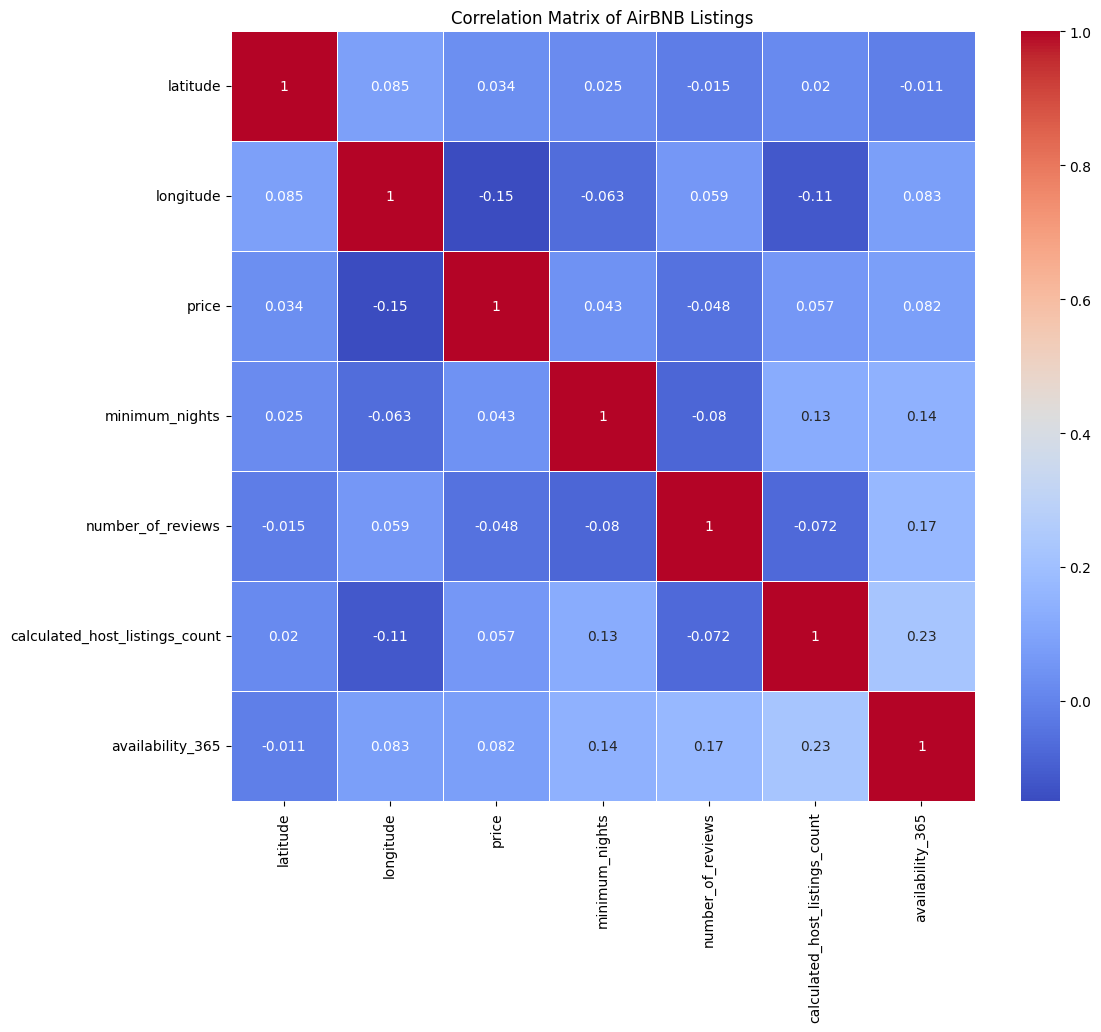

In [ ]:
# Drop the 'id', 'host_id', and 'reviews_per_month' columns
df = df.drop(columns=['id', 'host_id', 'reviews_per_month', 'last_review'])


# Select only numeric columns for the correlation matrix
numeric_cols = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of AirBNB Listings')
plt.show()


- No Correlation between any of the variables

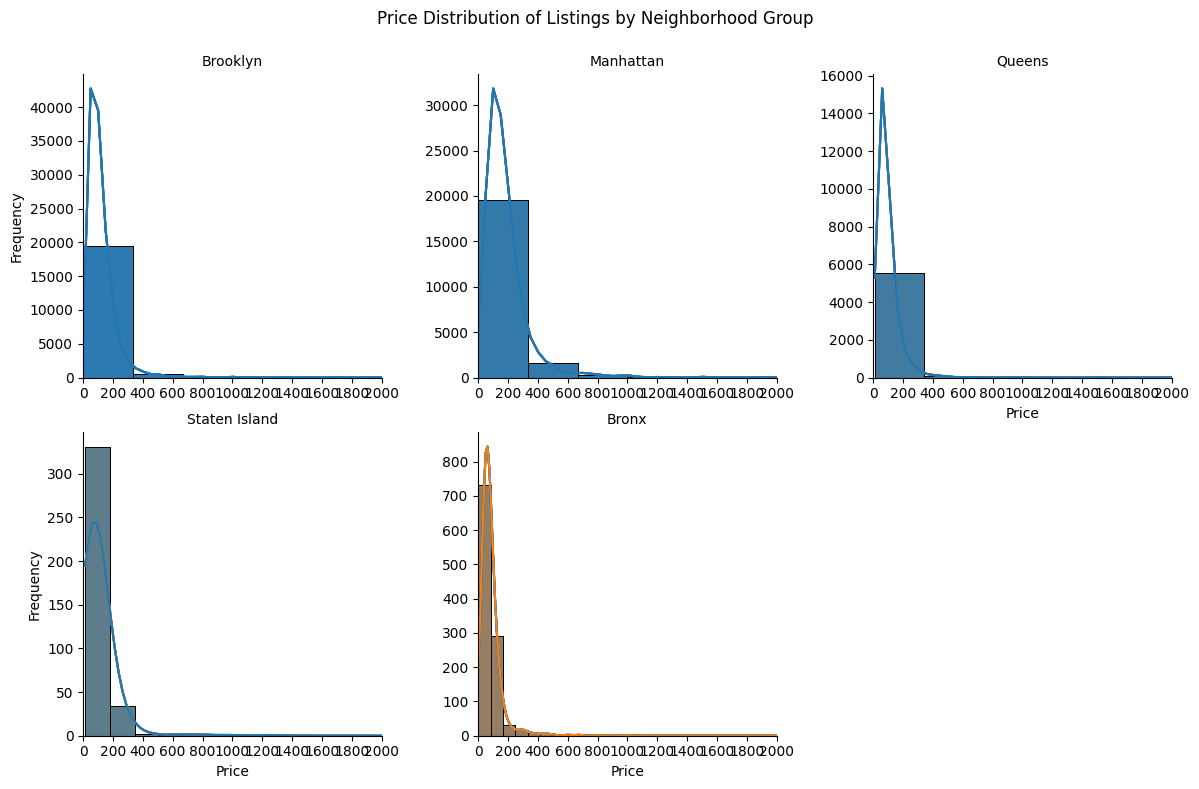

In [ ]:
neighborhood_colors = {
    'Brooklyn': 'dodgerblue',
    'Manhattan': 'darkorange',
    'Queens': 'forestgreen',
    'Staten Island': 'mediumvioletred',
    'Bronx': 'gold'
}

# Create the FacetGrid
g = sns.FacetGrid(df, col="neighbourhood_group", col_wrap=3, height=4, sharex=False, sharey=False)

# Map the histogram plot with custom colors
for neighborhood, color in neighborhood_colors.items():
    g.map_dataframe(sns.histplot, "price", bins=30, kde=True, color=color,
                    hue=df['neighbourhood_group'] == neighborhood)

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Price", "Frequency")

# Adjust the x-axis limits and ticks for better readability
for ax in g.axes.flat:
    ax.set_xlim(0, 2000)  # Set the x-axis limit to a more reasonable range
    ax.set_xticks(range(0, 2001, 200))  # Set the ticks at intervals of 200

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Price Distribution of Listings by Neighborhood Group')

plt.show()


Observations

Manhattan and Brooklyn: Both have the highest frequency of listings and the widest range of prices, including significant high-priced outliers.
Queens: Has a moderate frequency of listings with generally lower prices compared to Manhattan and Brooklyn.
Staten Island and Bronx: Both have lower frequencies of listings and more affordable prices, with limited outliers in the higher price ranges.

In [ ]:
# Filter listings for Manhattan, Brooklyn, and Queens
filtered_df = df[df['neighbourhood_group'].isin(['Manhattan', 'Brooklyn', 'Queens'])]

# Select relevant columns for summary statistics
columns_of_interest = ['neighbourhood_group', 'availability_365', 'number_of_reviews', 'minimum_nights', 'price', 'longitude', 'latitude']

# Compute mean and standard deviation for each neighborhood group
summary_stats = filtered_df[columns_of_interest].groupby('neighbourhood_group').agg(['mean', 'std']).reset_index()

# Flatten the MultiIndex columns
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

# Rename columns for better readability
summary_stats.rename(columns={
    'neighbourhood_group_': 'Neighborhood Group',
    'availability_365_mean': 'Availability Mean',
    'availability_365_std': 'Availability Std',
    'number_of_reviews_mean': 'Reviews Mean',
    'number_of_reviews_std': 'Reviews Std',
    'minimum_nights_mean': 'Min Nights Mean',
    'minimum_nights_std': 'Min Nights Std',
    'price_mean': 'Price Mean',
    'price_std': 'Price Std',
    'longitude_mean': 'Longitude Mean',
    'longitude_std': 'Longitude Std',
    'latitude_mean': 'Latitude Mean',
    'latitude_std': 'Latitude Std'
}, inplace=True)

# Style the DataFrame with a single color scheme
styled_stats = summary_stats.style.format({
    "Availability Mean": "{:.2f}", "Availability Std": "{:.2f}",
    "Reviews Mean": "{:.2f}", "Reviews Std": "{:.2f}",
    "Min Nights Mean": "{:.2f}", "Min Nights Std": "{:.2f}",
    "Price Mean": "{:.2f}", "Price Std": "{:.2f}",
    "Longitude Mean": "{:.5f}", "Longitude Std": "{:.5f}",
    "Latitude Mean": "{:.5f}", "Latitude Std": "{:.5f}"
}).background_gradient(cmap='Blues', subset=[
    "Availability Mean", "Availability Std", "Reviews Mean", "Reviews Std",
    "Min Nights Mean", "Min Nights Std", "Price Mean", "Price Std",
    "Longitude Mean", "Longitude Std", "Latitude Mean", "Latitude Std"
])

styled_stats

Location:

Manhattan's higher prices are likely driven by its central location and proximity to key attractions, business centers, and luxury amenities. The geographical coordinates suggest that high-end listings are located in desirable areas, which command premium prices.

Minimum Nights Requirement:

Higher minimum night requirements in Manhattan suggest that longer-term stays are more common, which could contribute to higher overall prices as hosts cater to guests looking for extended accommodations.

Listing Quality and Amenities:

The high standard deviation in prices for Manhattan indicates a wide range of listing qualities, from high-end apartments to luxury penthouses. The amenities and overall quality of listings likely play a significant role in driving prices up in this area.

Review Dynamics:

The number of reviews does not directly correlate with higher prices, particularly in Manhattan, where listings command high prices regardless of review count. This indicates that reputation and user feedback, while important, are secondary to location and quality in driving high-end prices.
In summary, the primary drivers of high-end Airbnb prices in Manhattan, Brooklyn, and Queens are likely related to location, quality of listings, and minimum stay requirements. Manhattan, in particular, benefits from its central location and the range of luxury offerings, which justify its higher prices.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Filter listings for Manhattan, Brooklyn, and Queens
filtered_df = df[df['neighbourhood_group'].isin(['Manhattan', 'Brooklyn'])]

filtered_df = filtered_df.sort_values(by='price', ascending=False)

# Select the top quartile based on price
top_quartile_threshold = filtered_df['price'].quantile(0.75)
top_quartile_df = filtered_df[filtered_df['price'] >= top_quartile_threshold]

# Select relevant columns, removing non-numeric columns for aggregation
columns_of_interest_numeric = ['availability_365', 'number_of_reviews', 'minimum_nights', 'price', 'longitude', 'latitude']

# Ensure 'neighbourhood_group' is included for grouping
columns_for_grouping = columns_of_interest_numeric + ['neighbourhood_group']

# Calculate mean and std for numeric columns only, grouped by neighbourhood_group
top_quartile_df[columns_for_grouping].groupby('neighbourhood_group').agg(['mean', 'std']).reset_index()

# Continue with the rest of your code...
top_quartile_df.isna().sum()

top_quartile_df = top_quartile_df.dropna()

# Select relevant columns
columns_of_interest = ['availability_365', 'number_of_reviews', 'minimum_nights', 'price', 'longitude', 'latitude', 'room_type', 'neighbourhood_group']

# Filter the relevant columns
top_quartile_df = top_quartile_df[columns_of_interest]


# Define the preprocessing steps for numerical and categorical data
numerical_features = ['availability_365', 'number_of_reviews', 'minimum_nights', 'price', 'longitude', 'latitude']
categorical_features = ['room_type', 'neighbourhood_group']

In [ ]:
numerical_transformer = StandardScaler()

# One-hot encode categorical features
categorical_transformer = OneHotEncoder(drop='first')

# Combine the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the transformations
X_preprocessed = preprocessor.fit_transform(top_quartile_df)

X_preprocessed

array([[-0.39312728, -0.4866207 ,  1.10879442, ...,  0.        ,
         0.        ,  1.        ],
       [-0.99489733, -0.34825709, -0.16542625, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99489733, -0.45894798, -0.16542625, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.99489733, -0.45894798, -0.36930156, ...,  1.        ,
         0.        ,  1.        ],
       [-0.49463066,  0.23287005, -0.2673639 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.99489733, -0.29291165, -0.31833273, ...,  0.        ,
         0.        ,  1.        ]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

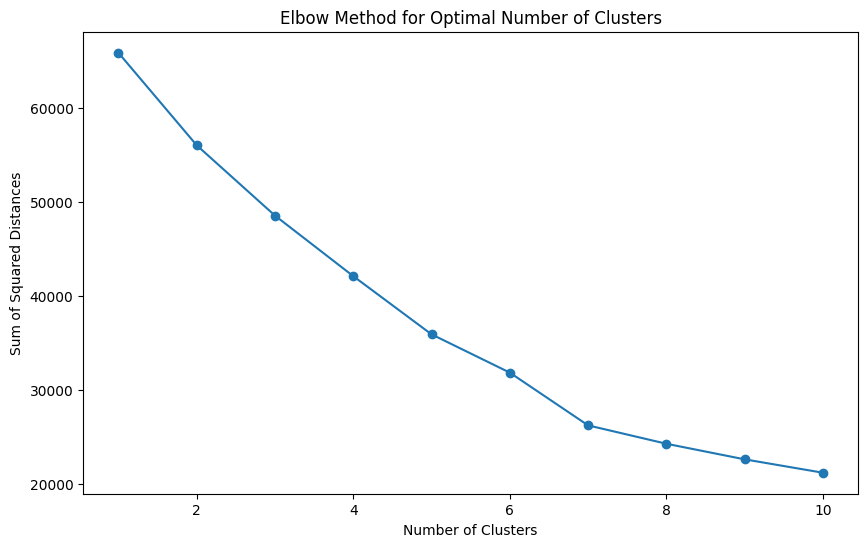

In [ ]:
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    sse.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

In the elbow plot:
The rate of decrease in the sum of squared distances is steep initially and starts to slow down after a certain point.
The elbow appears to be around 4 clusters, as the plot starts to bend at this point.
Conclusion
Based on the elbow method, the optimal number of clusters appears to be 4.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster  availability_365  number_of_reviews  minimum_nights     price  \
0        0          0.473071           3.040162       -0.211558 -0.157995   
1        1         -0.731996          -0.234407       -0.210802 -0.083292   
2        2          1.169521          -0.260402        0.520926  0.227285   
3        3         -0.256206          -0.147004       -0.191011 -0.079724   

   longitude  latitude  room_type_Private room  room_type_Shared room  \
0   0.034882 -0.070773                0.041076               0.002833   
1  -0.317529  0.423221                0.087322               0.007004   
2  -0.281126  0.374382                0.109417               0.001355   
3   0.851785 -1.128193                0.075924               0.003934   

   neighbourhood_group_Manhattan  
0                       0.674221  
1                       0.997432  
2                       0.956301  
3                       0.000000  


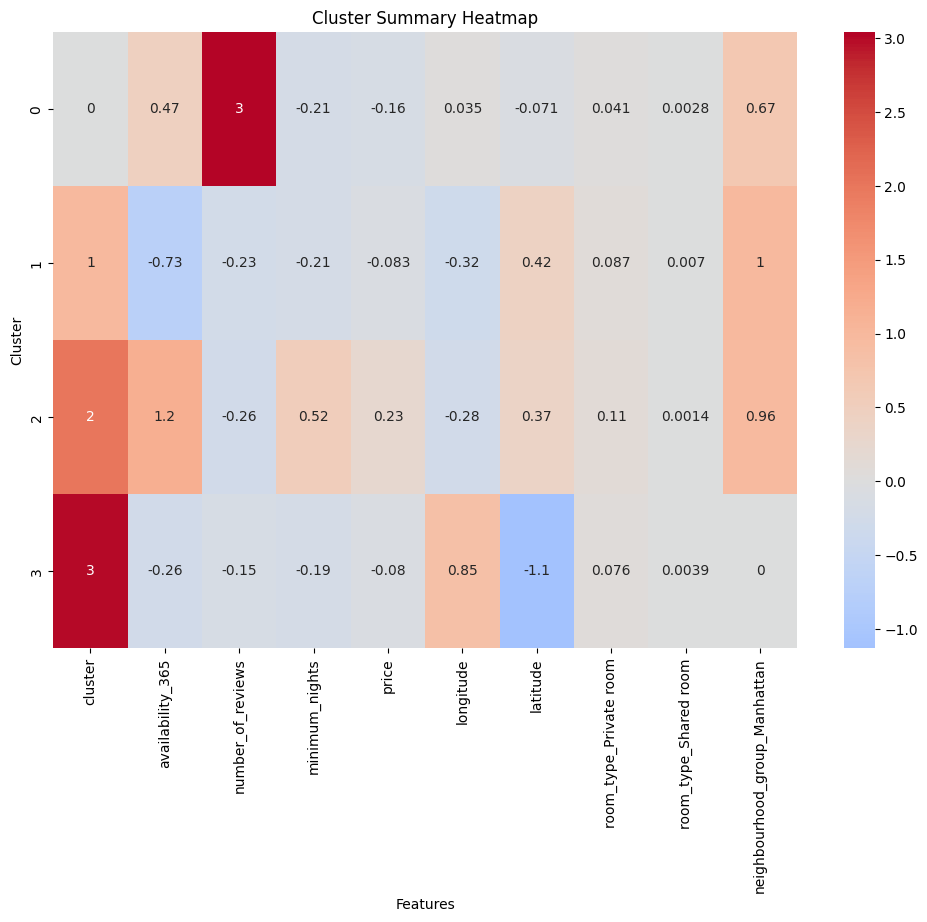

In [ ]:
from sklearn.cluster import KMeans

# Perform K-means clustering with the optimal number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_preprocessed)

# Get feature names after transformation
num_features = numerical_features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(num_features) + list(cat_features)

# Create a DataFrame from the preprocessed data
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# Add the cluster labels to the original DataFrame
X_preprocessed_df['cluster'] = clusters

# Group by the cluster labels and calculate the mean for each cluster
cluster_summary = X_preprocessed_df.groupby('cluster').mean().reset_index()

# Display the summary table
print(cluster_summary)


# Plot the heatmap with features on the y-axis and clusters on the x-axis
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm', center=0)
plt.title('Cluster Summary Heatmap')
plt.xlabel('Features')  # X-axis label for clusters
plt.ylabel('Cluster')  # Y-axis label for features
plt.show()




The analysis of the clusters reveals distinct profiles for travelers willing to spend more on Airbnb listings. High spenders, represented by Cluster 2, prefer entire homes or apartments in Manhattan, seek higher availability, and opt for longer stays. These luxury travelers prioritize comfort and extended accommodations, willing to pay premium prices for their stays.

In contrast, customers who not encesarily are the highest spenders but do spend a bit more than the avarageare spread across Clusters 0, 1, and 3. Cluster 0 consists of travelers who value highly-reviewed and popular listings in Manhattan. They prefer shorter stays and predominantly choose private rooms, indicating a strong emphasis on review quality and value for money. Cluster 1 includes travelers looking for cost-effective options with short stays in high-demand listings, also located in Manhattan. These travelers prioritize cost and booking convenience, often opting for private rooms. Finally, Cluster 3 represents budget-conscious travelers in Brooklyn who seek affordable entire homes or apartments. They prefer shorter stays and moderately popular listings, balancing cost and comfort in their accommodation choices.



In [ ]:
print(cluster_summary)

   cluster  availability_365  number_of_reviews  minimum_nights     price  \
0        0          0.473071           3.040162       -0.211558 -0.157995   
1        1         -0.731996          -0.234407       -0.210802 -0.083292   
2        2          1.169521          -0.260402        0.520926  0.227285   
3        3         -0.256206          -0.147004       -0.191011 -0.079724   

   longitude  latitude  room_type_Private room  room_type_Shared room  \
0   0.034882 -0.070773                0.041076               0.002833   
1  -0.317529  0.423221                0.087322               0.007004   
2  -0.281126  0.374382                0.109417               0.001355   
3   0.851785 -1.128193                0.075924               0.003934   

   neighbourhood_group_Manhattan  
0                       0.674221  
1                       0.997432  
2                       0.956301  
3                       0.000000  


In [ ]:
# Create a DataFrame from the preprocessed data
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# Add the cluster labels to the original DataFrame
X_preprocessed_df['cluster'] = clusters

In [ ]:
X_preprocessed_df.describe()

availability_365  number_of_reviews  minimum_nights         price  \
count      1.048300e+04       1.048300e+04    1.048300e+04  1.048300e+04   
mean       8.675901e-17       1.626731e-17   -2.575658e-17  5.422438e-17   
std        1.000048e+00       1.000048e+00    1.000048e+00  1.000048e+00   
min       -9.948973e-01      -4.866207e-01   -3.693016e-01 -3.678083e-01   
25%       -9.948973e-01      -4.866207e-01   -3.183327e-01 -3.247406e-01   
50%       -3.568761e-01      -4.036025e-01   -2.673639e-01 -2.295383e-01   
75%        9.916688e-01      -4.385716e-02   -1.654262e-01 -2.866321e-03   
max        1.651441e+00       1.188309e+01    1.823432e+01  2.187098e+01   

          longitude      latitude  room_type_Private room  \
count  1.048300e+04  1.048300e+04            10483.000000   
mean  -2.459293e-13 -2.139152e-15                0.087666   
std    1.000048e+00  1.000048e+00                0.282822   
min   -2.669304e+00 -4.293176e+00                0.000000   
25%   -7.656266e-01 -5.739172e-01                0.000000   
50%   -2.062254e-01 -3.067536e-02                0.000000   
75%    7.396384e-01  6.850763e-01                0.000000   
max    5.012598e+00  3.710754e+00                1.000000   

       room_type_Shared room  neighbourhood_group_Manhattan       cluster  
count           10483.000000                   10483.000000  10483.000000  
mean                0.004388                       0.722217      1.699227  
std                 0.066100                       0.447927      0.911075  
min                 0.000000                       0.000000      0.000000  
25%                 0.000000                       0.000000      1.000000  
50%                 0.000000                       1.000000      2.000000  
75%                 0.000000                       1.000000      2.000000  
max                 1.000000                       1.000000      3.000000

In [ ]:
top_listing_price = X_preprocessed_df['price'].quantile(0.95)
top_listings = X_preprocessed_df[X_preprocessed_df['price'] > top_listing_price]
print(top_listings)

     availability_365  number_of_reviews  minimum_nights      price  \
0           -0.393127          -0.486621        1.108794  21.870983   
1           -0.994897          -0.348257       -0.165426  21.870983   
2           -0.994897          -0.458948       -0.165426  21.868716   
3            1.651441          -0.486621        1.108794  21.868716   
4           -0.393127          -0.320584        4.625643  21.868716   
..                ...                ...             ...        ...   
480          0.643657          -0.486621       -0.267364   0.983157   
481         -0.994897          -0.486621       -0.267364   0.971823   
482          1.557188          -0.126875        1.108794   0.940089   
483          1.122173          -0.458948        0.293293   0.926489   
484          1.622440          -0.292912       -0.318333   0.926489   

     longitude  latitude  room_type_Private room  room_type_Shared room  \
0    -0.435307  0.979983                     0.0                    0.0 

In [ ]:
top_listing_indices = top_listings.index
top_listing_clusters = clusters[top_listing_indices]
top_listings['y'] = top_listing_clusters



<ipython-input-144-9875e1f77dd9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_listings['y'] = top_listing_clusters


In [ ]:
import pandas as pd


top_listings = pd.DataFrame(top_listings, columns=feature_names)


top_listings['y'] = top_listing_clusters

cluster0 = top_listings[['latitude', "longitude"]][top_listings['y'] == 0].values.tolist()
cluster1 = top_listings[['latitude', "longitude"]][top_listings['y'] == 0].values.tolist()
cluster2 = top_listings[['latitude', "longitude"]][top_listings['y'] == 1].values.tolist()
cluster3 = top_listings[['latitude', "longitude"]][top_listings['y'] == 2].values.tolist()

print(cluster0)
print(cluster1)
print(cluster2)
print(cluster3)



[[0.1983756664004273, -1.0517532511584478], [0.5725185802418771, -0.28378849335894585], [-1.2950475212471435, 1.1344435461466809], [0.39095694182791146, -0.7581859832032153], [-1.1113869043544835, 0.39308473121942905], [-1.0665212393706192, 0.2118035611453455], [-0.09154573598014615, -1.012069810943557], [0.15482186296584013, -0.5859237768153246], [-1.308166136739543, 0.9969043499464991], [-0.5042573793690042, -0.6918966001167153]]
[[0.1983756664004273, -1.0517532511584478], [0.5725185802418771, -0.28378849335894585], [-1.2950475212471435, 1.1344435461466809], [0.39095694182791146, -0.7581859832032153], [-1.1113869043544835, 0.39308473121942905], [-1.0665212393706192, 0.2118035611453455], [-0.09154573598014615, -1.012069810943557], [0.15482186296584013, -0.5859237768153246], [-1.308166136739543, 0.9969043499464991], [-0.5042573793690042, -0.6918966001167153]]
[[1.5737313146169625, 0.180688136431601], [-0.040645507869942074, -0.5227910310183832], [0.09788707172910995, -0.682426688247398

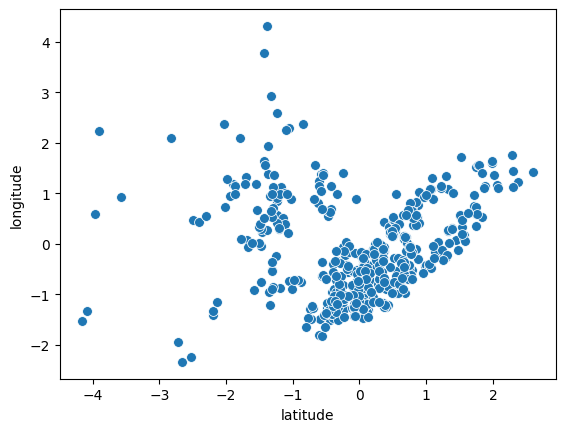

In [ ]:
#location of listings
ax = sns.scatterplot(data = top_listings,
                     x = 'latitude',
                     y = 'longitude',
                     s = 50)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 4, n_init = 25, random_state = 1234)
km.fit(top_listings)

KMeans(n_clusters=4, n_init=25, random_state=1234)

In [ ]:
km.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
km.inertia_

3217.9526810968728

In [ ]:
pd.Series(km.labels_).value_counts().sort_index() #number of values in each cluster

0    400
1     17
2     57
3     11
Name: count, dtype: int64

In [ ]:
km.cluster_centers_

array([[ 3.37606436e-01, -2.01937578e-01, -1.24396343e-01,
         1.71880395e+00, -1.84077086e-01, -4.43025794e-03,
         1.75000000e-01,  7.50000000e-03,  7.77500000e-01,
         1.81500000e+00],
       [ 3.12705055e-01, -4.21508411e-01,  8.71939286e-01,
         1.70600695e+01, -2.23181256e-02,  3.13980054e-03,
         1.76470588e-01, -1.73472348e-18,  7.64705882e-01,
         2.11764706e+00],
       [ 3.78451054e-01, -3.62336194e-01,  2.29805707e-01,
         6.80751419e+00, -2.08946918e-01,  7.25842544e-02,
         1.22807018e-01,  3.46944695e-18,  8.07017544e-01,
         1.98245614e+00],
       [ 9.02029500e-01, -3.83476918e-01,  6.80340244e+00,
         3.47902186e+00,  2.89448639e-01, -4.11616102e-01,
         4.54545455e-01,  0.00000000e+00,  6.36363636e-01,
         2.00000000e+00]])

In [ ]:
top_listings.columns

Index(['availability_365', 'number_of_reviews', 'minimum_nights', 'price',
       'longitude', 'latitude', 'room_type_Private room',
       'room_type_Shared room', 'neighbourhood_group_Manhattan', 'y'],
      dtype='object')

In [ ]:
cluster_centers = pd.DataFrame(km.cluster_centers_,
                               columns = ['availability_365', 'number_of_reviews', 'minimum_nights', 'price',
       'longitude', 'latitude', 'room_type_Private room',
       'room_type_Shared room', 'neighbourhood_group_Manhattan', 'y'])
cluster_centers

availability_365  number_of_reviews  minimum_nights      price  longitude  \
0          0.337606          -0.201938       -0.124396   1.718804  -0.184077   
1          0.312705          -0.421508        0.871939  17.060069  -0.022318   
2          0.378451          -0.362336        0.229806   6.807514  -0.208947   
3          0.902029          -0.383477        6.803402   3.479022   0.289449   

   latitude  room_type_Private room  room_type_Shared room  \
0 -0.004430                0.175000           7.500000e-03   
1  0.003140                0.176471          -1.734723e-18   
2  0.072584                0.122807           3.469447e-18   
3 -0.411616                0.454545           0.000000e+00   

   neighbourhood_group_Manhattan         y  
0                       0.777500  1.815000  
1                       0.764706  2.117647  
2                       0.807018  1.982456  
3                       0.636364  2.000000

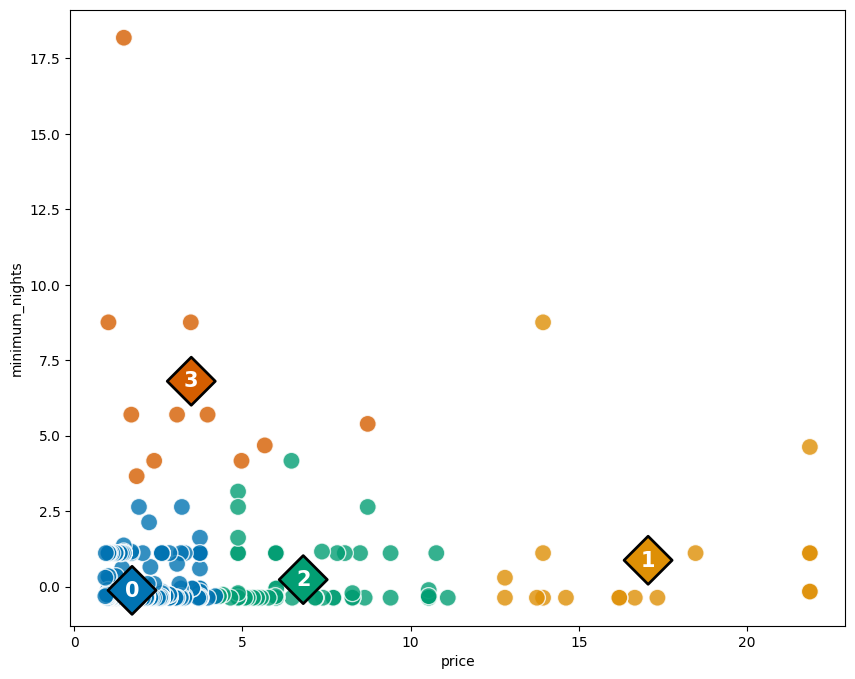

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 8))

#Plot the Clusters
ax = sns.scatterplot(data = top_listings,
                     x = 'price',
                     y = 'minimum_nights',
                     hue = km.labels_,
                     palette = 'colorblind',
                     alpha = 0.8,
                     s = 150,
                     legend = False)

#Plot the Centroids
ax = sns.scatterplot(data = cluster_centers,
                     x = 'price',
                     y = 'minimum_nights',
                     hue = cluster_centers.index,
                     palette = 'colorblind',
                     s = 600,
                     marker = 'D',
                     ec = 'black',
                     legend = False)

# Add Centroid Labels
for i in range(len(cluster_centers)):
               plt.text(x = cluster_centers.price[i],
                        y = cluster_centers.minimum_nights[i],
                        s = i,
                        horizontalalignment='center',
                        verticalalignment='center',
                        size = 15,
                        weight = 'bold',
                        color = 'white')

[]

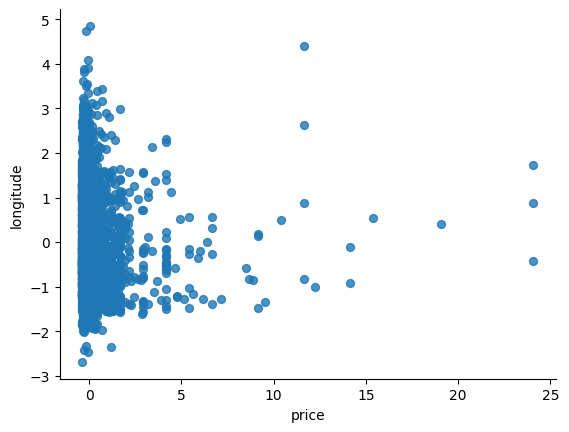

In [ ]:
# @title price vs longitude

from matplotlib import pyplot as plt
X_preprocessed_df.plot(kind='scatter', x='price', y='longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
!pip install geopandas
import geopandas
!pip install folium matplotlib mapclassify
!pip install folium
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from IPython.display import IFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nyc_boroughs = geopandas.read_file(
    "/content/drive/MyDrive/Colab Notebooks/nyu_2451_34154/nyu_2451_34154.shp"
)
nyc_boroughs.explore("SHAPE_AREA", legend=False)

In [ ]:


# Save the DataFrame to a CSV file
top_listings.to_csv('preprocessed_data.csv', index=False)

Random CLustering

In [ ]:
df.head()

name    host_name  \
0                Clean & quiet apt home by the park         John   
1                             Skylit Midtown Castle     Jennifer   
2               THE VILLAGE OF HARLEM....NEW YORK !    Elisabeth   
3                   Cozy Entire Floor of Brownstone  LisaRoxanne   
4  Entire Apt: Spacious Studio/Loft by central park        Laura   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   
3            Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt   
4           Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt   

   price  minimum_nights  number_of_reviews  calculated_host_listings_count  \
0    149               1                  9                               6   
1    225               1                 45                               2   
2    150               3                  0                               1   
3     89               1                270                               1   
4     80              10                  9                               1   

   availability_365  
0               365  
1               355  
2               365  
3               194  
4                 0

In [ ]:
x = df[["latitude", "longitude"]]
x.head()

latitude  longitude
0  40.64749  -73.97237
1  40.75362  -73.98377
2  40.80902  -73.94190
3  40.68514  -73.95976
4  40.79851  -73.94399

In [ ]:
model = KMeans(n_clusters=3)
y_kmeans = model.fit_predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df['y'] = y_kmeans


In [ ]:
df.head()


name    host_name  \
0                Clean & quiet apt home by the park         John   
1                             Skylit Midtown Castle     Jennifer   
2               THE VILLAGE OF HARLEM....NEW YORK !    Elisabeth   
3                   Cozy Entire Floor of Brownstone  LisaRoxanne   
4  Entire Apt: Spacious Studio/Loft by central park        Laura   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   
3            Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt   
4           Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt   

   price  minimum_nights  number_of_reviews  calculated_host_listings_count  \
0    149               1                  9                               6   
1    225               1                 45                               2   
2    150               3                  0                               1   
3     89               1                270                               1   
4     80              10                  9                               1   

   availability_365  y  
0               365  1  
1               355  0  
2               365  0  
3               194  1  
4                 0  0

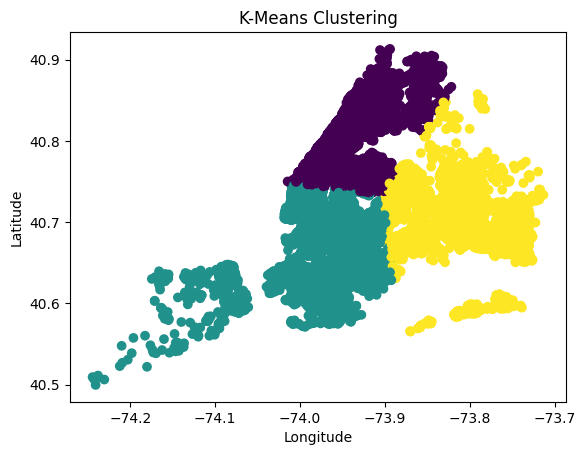

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['longitude'], df['latitude'], c=df['y'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
model.inertia_


108.83128176099223

In [ ]:
wcss = []
for i in range(1,11):
    model = KMeans(n_clusters=i)
    y_kmeans = model.fit_predict(x)
    wcss.append(model.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

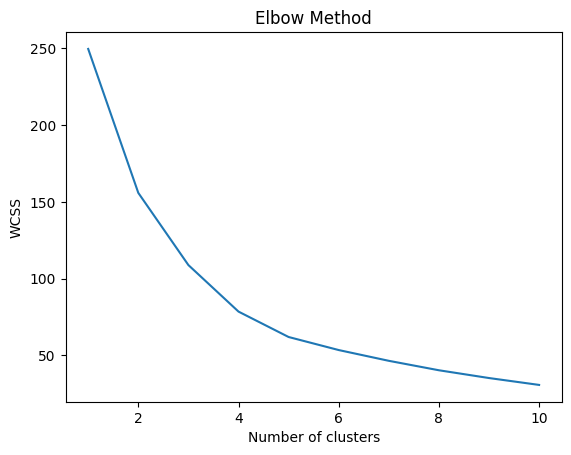

In [ ]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [ ]:
df = df[:500]

cluster0 =df[["latitude","longitude"]][df['y'] == 0].values.tolist()
cluster1 =df[["latitude","longitude"]][df['y'] == 1].values.tolist()
cluster2 =df[["latitude","longitude"]][df['y'] == 2].values.tolist()

In [ ]:
import folium
import pandas as pd
from IPython.display import display

manhattan = nyc_boroughs[nyc_boroughs['BORONAME'] == 'Manhattan']

def plot_Manhattan_Map(df, manhattan):
    # Creating a map centered around Manhattan
    manhat_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10,tiles = "openstreetmap")

    return manhat_map # Return the map object

# Call the function to create the map
manhat_map = plot_Manhattan_Map(df, manhattan)

# Now you can display the map
manhat_map

In [ ]:
for i in cluster0:
    folium.CircleMarker(i, radius=2,color='blue',fill_color='lightblue').add_to(manhat_map)

for i in cluster1:
  folium.CircleMarker(i, radius=2,color='red',fill_color='lightred').add_to(manhat_map)

for i in cluster2:
   folium.CircleMarker(i, radius=2,color='green',fill_color='lightgreen').add_to(manhat_map)

In [ ]:
from os import popen
import folium
from folium.plugins import MarkerCluster




In [ ]:
manhat_map

In [ ]:
cluster1_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10,tiles = "openstreetmap")

for i in cluster1:
  folium.CircleMarker(i, radius=2,color='red',fill_color='lightred').add_to(cluster1_map)


In [ ]:
cluster1_map

In [ ]:
cluster2_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10,tiles = "openstreetmap")

for i in cluster2:
  folium.CircleMarker(i, radius=2,color='green',fill_color='lightgreen').add_to(cluster2_map)

In [ ]:
cluster2_map

In [ ]:
import folium
import pandas as pd
from IPython.display import display

manhattan = nyc_boroughs[nyc_boroughs['BORONAME'] == 'Manhattan']

def plot_Manhattan_Map(df, manhattan):
    # Creating a map centered around Manhattan
    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10,tiles = "openstreetmap")

    data = df[["latitude", "longitude",  "y", "price"]]

    # Add markers for data points
    for index, row in data.iterrows():
        tooltip = f"Price: {row['price']}, Location: {row['latitude']}, {row['longitude']}"
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            #popup=row["neighbourhood"],
            tooltip=tooltip,
        ).add_to(nyc_map)

    # Color the boroughs using Choropleth
    folium.Choropleth(
        geo_data=nyc_boroughs,
        fill_color="blue",
        fill_opacity=0.2,
        line_opacity=0.2,
    ).add_to(nyc_map)

    return nyc_map
highest50_map = plot_Manhattan_Map(df.sort_values(by="price", ascending=False).head(50), manhattan)


# Display the maps in Google Colab

display(highest50_map)

The following section looks at the top listings in New York by price.

In [ ]:
top_listing_price = df['price'].quantile(0.75)
top_bookings = df[df['price'] > top_listing_price]
# Use the logical OR operator (|) to combine conditions for 'Manhattan' or 'Brooklyn'
top_bookings = top_bookings[ (top_bookings['neighbourhood_group'] == 'Manhattan') | (top_bookings['neighbourhood_group'] == 'Brooklyn')]
print(top_bookings)

                                          name host_name neighbourhood_group  \
1                        Skylit Midtown Castle  Jennifer           Manhattan   
5    Large Cozy 1 BR Apartment In Midtown East     Chris           Manhattan   
16           Perfect for Your Parents + Garden      Jane            Brooklyn   
19           Huge 2 BR Upper East  Cental Park      Sing           Manhattan   
20            Sweet and Spacious Brooklyn Loft     Chaya            Brooklyn   
..                                         ...       ...                 ...   
475                   Gorgeous Duplex + Garden      Adam            Brooklyn   
478          Light-filled East Village Delight     Chris           Manhattan   
480             Spacious Duplex in Brownstone!    Benton           Manhattan   
494          Elegant 2-BR duplex, Union Square     Donna           Manhattan   
496      Luxury 2Bed/2.5Bath Central Park View     Henry           Manhattan   

       neighbourhood  latitude  longitu

In [ ]:
top_bookings

name host_name neighbourhood_group  \
1                        Skylit Midtown Castle  Jennifer           Manhattan   
5    Large Cozy 1 BR Apartment In Midtown East     Chris           Manhattan   
16           Perfect for Your Parents + Garden      Jane            Brooklyn   
19           Huge 2 BR Upper East  Cental Park      Sing           Manhattan   
20            Sweet and Spacious Brooklyn Loft     Chaya            Brooklyn   
..                                         ...       ...                 ...   
475                   Gorgeous Duplex + Garden      Adam            Brooklyn   
478          Light-filled East Village Delight     Chris           Manhattan   
480             Spacious Duplex in Brownstone!    Benton           Manhattan   
494          Elegant 2-BR duplex, Union Square     Donna           Manhattan   
496      Luxury 2Bed/2.5Bath Central Park View     Henry           Manhattan   

       neighbourhood  latitude  longitude        room_type  price  \
1            Midtown  40.75362  -73.98377  Entire home/apt    225   
5        Murray Hill  40.74767  -73.97500  Entire home/apt    200   
16       Fort Greene  40.69169  -73.97185  Entire home/apt    215   
19       East Harlem  40.79685  -73.94872  Entire home/apt    190   
20      Williamsburg  40.71842  -73.95718  Entire home/apt    299   
..               ...       ...        ...              ...    ...   
475       Park Slope  40.67853  -73.98089  Entire home/apt    219   
478     East Village  40.72578  -73.97879  Entire home/apt    190   
480      East Harlem  40.80113  -73.94503  Entire home/apt    250   
494         Gramercy  40.73476  -73.98452  Entire home/apt    400   
496  Upper West Side  40.77350  -73.98697  Entire home/apt   2000   

     minimum_nights  number_of_reviews  calculated_host_listings_count  \
1                 1                 45                               2   
5                 3                 74                               1   
16                2                198                               1   
19                7                  0                               2   
20                3                  9                               1   
..              ...                ...                             ...   
475               5                  2                               1   
478               3                147                               1   
480               2                 11                               2   
494               2                105                               1   
496              30                 30                              11   

     availability_365  y  
1                 355  0  
5                 129  0  
16                321  1  
19                249  0  
20                  0  1  
..                ... ..  
475                 0  1  
478                27  1  
480                68  0  
494               304  1  
496                 0  0  

[123 rows x 13 columns]

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(top_bookings['longitude'], top_bookings['latitude'], c=top_bookings['y'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering_Top Lisitings_Manhattan & Brooklyn')
plt.show()

KeyError: 'y'

In [ ]:
wcss = []
for i in range(1,14):
    model = KMeans(n_clusters=i)
    y_kmeans = model.fit_predict(x)
    wcss.append(model.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

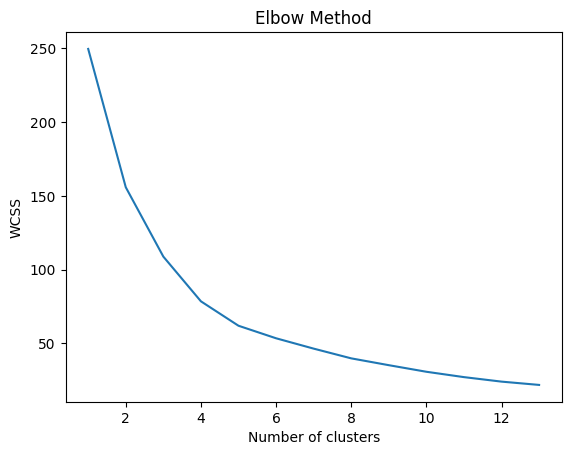

In [ ]:
plt.plot(range(1, 14), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [ ]:
top_listings = top_listings[:500]

cluster0 = top_bookings[["latitude","longitude"]][top_bookings['y'] == 0].values.tolist()
cluster1 = top_bookings[["latitude","longitude"]][top_bookings['y'] == 1].values.tolist()
cluster2 = top_bookings[["latitude","longitude"]][top_bookings['y'] == 2].values.tolist()



In [ ]:
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=10,tiles = "openstreetmap")
location=top_bookings[["latitude","longitude"]]
plugins.MarkerCluster(location).add_to(map_nyc)

for i in cluster0:
    folium.CircleMarker(i, radius=2,color='blue',fill_color='lightblue').add_to(map_nyc)

for i in cluster1:
    folium.CircleMarker(i, radius=2,color='red',fill_color='lightred').add_to(map_nyc)

for i in cluster2:
    folium.CircleMarker(i, radius=2,color='green',fill_color='lightgreen').add_to(map_nyc)

# Only show Manhattan and Brooklyn
manhattan_data = nyc_boroughs[nyc_boroughs['BORONAME'] == 'Manhattan']
brooklyn_data = nyc_boroughs[nyc_boroughs['BORONAME'] == 'Brooklyn']

# Combine the two GeoDataFrames using the union operation
combined_data = manhattan_data.union(brooklyn_data)

folium.Choropleth(
    geo_data= combined_data,
    fill_color="blue",
    fill_opacity=0.2,
    line_opacity=0.2,
).add_to(map_nyc)

# This block was indented, causing the error. It should be at the same level as the for loops above.
data = top_bookings[["neighbourhood", "latitude", "longitude","y","price", "room_type","neighbourhood_group"]]

# Add markers for data points
for index, row in data.iterrows():
    tooltip = f"Borough: {row['neighbourhood']},Type:{row['room_type']}, Price: {row['price']}, Location: {row['neighbourhood_group']}"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        popup=row["neighbourhood"],
        tooltip=tooltip,
    ).add_to(map_nyc)


/usr/local/lib/python3.10/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:968: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:969: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:970: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:971: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:968: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:969: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/us

In [ ]:
display(map_nyc)

The displayed looks at the different clusters of the top priced listings in New York.